<a href="https://colab.research.google.com/github/offthetab/3-JavaClass-/blob/main/Conditional_VAE_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# download at first and restart kernel if needed
%%capture
!pip install torchinfo
!pip install torchvision==0.19.0
!pip install pytorch-ignite

In [ ]:
import random
import torch as th
import numpy as np

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets
from torchvision.transforms.v2 import ToTensor, Compose, Normalize
from torchinfo import summary

from ignite.metrics import SSIM, PSNR, MeanSquaredError
from ignite.engine import Engine

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

from scipy.stats import norm


/usr/local/lib/python3.10/dist-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


In [ ]:
random.seed(0)
np.random.seed(0)
th.manual_seed(0)
th.cuda.manual_seed(0)
th.backends.cudnn.deterministic=True

In [ ]:
train_MNIST = datasets.MNIST('./data', download = True, train = True, transform=ToTensor())
test_MNIST = datasets.MNIST('./data', download = True, train = False, transform=ToTensor())

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 17563125.31it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 484944.31it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4295491.34it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 7917925.51it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# Define dataloaders to get batches
batch_size = 128
train_loader = DataLoader(train_MNIST, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_MNIST, batch_size=batch_size, shuffle=False)

In [ ]:
# torch.Size([32, 1, 28, 28] BCHW
train_batch, train_labels = next(iter(train_loader))
train_batch.shape, train_labels.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [ ]:
class Encoder(th.nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = th.nn.Sequential(
            th.nn.Conv2d(in_channels=1, out_channels=16,  kernel_size=(3,3), stride=(1, 1), padding=(1, 1)),
            th.nn.BatchNorm2d(16),
            th.nn.ReLU(),
            th.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),

            th.nn.Conv2d(in_channels=16, out_channels=32,  kernel_size=(3,3), stride=(1, 1), padding=(1, 1)),
            th.nn.ReLU(),
            th.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),

            th.nn.Flatten(),
            th.nn.Linear(in_features=32*7*7, out_features=4*7*7),
            th.nn.ReLU(),

        )
        self.fc_mean = th.nn.Sequential(
            th.nn.Linear(in_features=4*7*7, out_features=100),
        )
        self.fc_logvar = th.nn.Sequential(
            th.nn.Linear(in_features=4*7*7, out_features=100),
        )

    def forward(self, x):
        tmp = self.encoder(x)
        mean = self.fc_mean(tmp)
        logvar = self.fc_logvar(tmp)
        return mean, logvar

In [ ]:
class Decoder(th.nn.Module):
    def __init__(self, class_num: int, embed_size: int):
        super(Decoder, self).__init__()

        self.label_emb = th.nn.Embedding(class_num, embed_size)

        self.decoder = th.nn.Sequential(
            th.nn.Linear(in_features=100+embed_size, out_features=4*7*7),
            th.nn.ReLU(),
            th.nn.Linear(in_features=4*7*7, out_features=32*7*7),
            th.nn.ReLU(),
            th.nn.Unflatten(1, (32, 7, 7)),

            th.nn.Upsample(scale_factor=2, mode='bilinear'),
            th.nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=(3,3), padding=(1, 1)),
            th.nn.BatchNorm2d(16),
            th.nn.ReLU(),

            th.nn.Upsample(scale_factor=2, mode='bilinear'),
            th.nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=(3,3), padding=(1, 1)),
            th.nn.Sigmoid()
        )

    def forward(self, x):
        z = x[:, :100]
        number = self.label_emb(x[:, 100].long())
        x = th.cat([z,number],dim=1)
        return self.decoder(x)

In [ ]:
class WeightInit():
    def ConvInit(self, layer):
        if isinstance(layer, (th.nn.Conv2d, th.nn.ConvTranspose2d, th.nn.Linear)):
            th.nn.init.xavier_uniform_(layer.weight)
            th.nn.init.zeros_(layer.bias)

In [ ]:
class CVAE(th.nn.Module):
    def __init__(self, Encoder, Decoder):
        super(CVAE, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

        weightinit = WeightInit()

        Encoder.apply(weightinit.ConvInit)
        Decoder.apply(weightinit.ConvInit)

    def reparameterization(self, mean, logvar): # reparameterization trick
        std = th.exp(0.5*logvar)
        eps = th.randn_like(std)
        return mean + eps*std

    def forward(self, x, label):
        mean, logvar = self.Encoder(x)
        z = self.reparameterization(mean, logvar) # log var to var

        z = th.cat([z, label.unsqueeze(dim=1)], dim=1)
        return self.Decoder(z), mean, logvar

In [ ]:
device = th.device('cuda:0' if th.cuda.is_available() else 'cpu')

encoder = Encoder().to(device)
decoder = Decoder(class_num=len(train_MNIST.classes), embed_size=5).to(device)

net = CVAE(Encoder=encoder, Decoder=decoder).to(device)

In [ ]:
#  beta regulates balance between MSE and KL. As the value 𝛽 increases, the influence of the KL divergence term
#  in the loss function becomes stronger so latent space tends to be more normal distributed,
#  but this results in a trade-off where the quality of reconstruction (measured by MSE) might decrease.
# beta = 1 lr=0.001 pretty good results
# beta = 1 baaaad

def loss_function(reconstructed_image, image, mean, logvar, beta=0.5):
    MSE = th.nn.functional.mse_loss(reconstructed_image.flatten(), image.flatten(), reduction='sum')
    KL = (-0.5 * th.sum(1 + logvar - mean.pow(2) - logvar.exp()))
    return MSE + beta * KL

opt = th.optim.Adam(net.parameters(), lr=0.001, betas=(0.6, 0.999), weight_decay=0.005)

In [ ]:
train_loss_values = []

num_epochs = 50

for epoch in tqdm(range(1, num_epochs+1)):
    train_loss = 0  # cumulative loss value
    for idx, (images, labels) in enumerate(train_loader):
        images = images.to(device) # send batch to CPU or GRU
        labels = labels.to(device)

        net.train()
        reconstructed_image, mean, logvar = net.forward(images, labels) # model predict
        loss_value = loss_function(reconstructed_image, images, mean, logvar)
        train_loss += loss_value.item()

        opt.zero_grad()
        loss_value.backward()
        opt.step()

    train_loss /= len(train_loader)
    train_loss_values.append(train_loss)
    print(f'Epoch: {epoch}; Train MSE + KL loss: {train_loss}')


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1; Train MSE + KL loss: 5219.638393377699
Epoch: 2; Train MSE + KL loss: 3683.7921790669975
Epoch: 3; Train MSE + KL loss: 3228.588976504198
Epoch: 4; Train MSE + KL loss: 2971.1612020464086
Epoch: 5; Train MSE + KL loss: 2826.218850467251
Epoch: 6; Train MSE + KL loss: 2737.172934591135
Epoch: 7; Train MSE + KL loss: 2674.2744145830557
Epoch: 8; Train MSE + KL loss: 2628.5731136102413
Epoch: 9; Train MSE + KL loss: 2591.141591151386
Epoch: 10; Train MSE + KL loss: 2561.3645802967585
Epoch: 11; Train MSE + KL loss: 2537.0165877677737
Epoch: 12; Train MSE + KL loss: 2510.142453451909
Epoch: 13; Train MSE + KL loss: 2491.088735226629
Epoch: 14; Train MSE + KL loss: 2472.830021904984
Epoch: 15; Train MSE + KL loss: 2459.52112935601
Epoch: 16; Train MSE + KL loss: 2440.1646606185036
Epoch: 17; Train MSE + KL loss: 2426.3702442030917
Epoch: 18; Train MSE + KL loss: 2411.4092452775185
Epoch: 19; Train MSE + KL loss: 2403.707456023454
Epoch: 20; Train MSE + KL loss: 2387.834450012077
E

In [ ]:
# Define the evaluation step
def eval_step(engine, batch):
    net.eval()
    with th.no_grad():
        image, label = batch
        # noised_images = noise(data)
        # noised_images = noised_images.to(device)
        image = image.to(device)
        label = label.to(device)

        reconstructed_image, _, _ = net(image, label)
        return reconstructed_image, image

# Create the evaluation engine
engine = Engine(eval_step)

# Create the SSIM metric
ssim_metric = SSIM(data_range=1.0)
ssim_metric.attach(engine, 'ssim')

# Run the evaluation
state = engine.run(test_loader)

# Print the average SSIM
SSIM_value = round(state.metrics["ssim"], 3)
print(f'Average SSIM: {SSIM_value}')

# Create the PSNR metric
psnr_metric = PSNR(data_range=1.0)
psnr_metric.attach(engine, 'psnr')

# Run the evaluation
state = engine.run(test_loader)

# Print the average PSNR
PSNR_value = round(state.metrics["psnr"], 3)
print(f'Average PSNR: {PSNR_value}')

Average SSIM: 0.871
Average PSNR: 19.201


<Figure size 1600x1200 with 0 Axes>

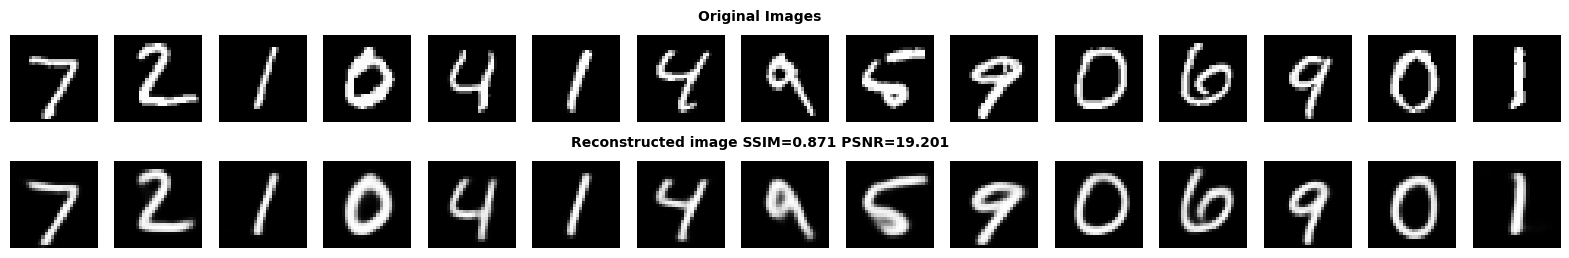

In [ ]:
net.eval()
with th.no_grad():
    for image, label in test_loader:
        image = image.to(device)
        label = label.to(device)

        reconstructed_image, _, _ = net(image, label)
        break

plt.figure(dpi=250)
fig, ax = plt.subplots(2, 15, figsize=(20, 3))
for i in range(15):
    ax[0, i].imshow(image[i].cpu().numpy().transpose((1, 2, 0)), cmap='gray')
    ax[1, i].imshow(reconstructed_image[i].cpu().numpy().transpose((1, 2, 0)), cmap='gray')
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')

fig.text(0.5, 0.91, 'Original Images', ha='center', va='center', fontsize=10, fontweight='bold')
fig.text(0.5, 0.49, f'Reconstructed image SSIM={SSIM_value} PSNR={PSNR_value}', ha='center', va='center', fontsize=10, fontweight='bold')

plt.show()

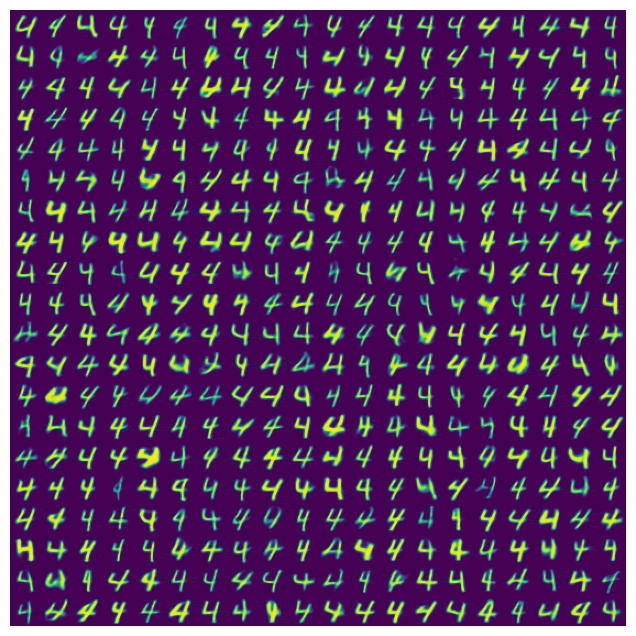

In [ ]:
digit_to_show = 4 # from 0 to 9
n = 20
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

with th.no_grad():
  for i in range(n):
      for j in range(n):
          z_sample = th.cat([th.randn(100).reshape(1, 100), th.Tensor([digit_to_show]).unsqueeze(dim=1)], dim=1)
          z_sample = z_sample.to(device)
          x_decoded = decoder(z_sample)
          digit = x_decoded[0].cpu().numpy().reshape(digit_size, digit_size)
          figure[i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(8, 8))
plt.imshow(figure)
plt.axis('off')
plt.show()